[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph. 

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of student assignment submissions
class AssignmentSubmission(TypedDict):
    id: str
    student_name: str
    course: str
    assignment: Optional[str]
    submission: str
    score: Optional[int]
    reviewer: Optional[str]
    comments: Optional[str]


## Sub graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

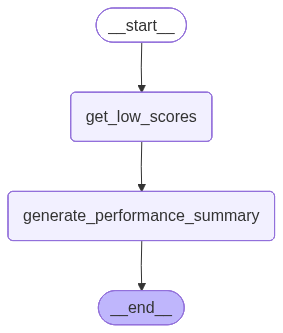

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Low Performance Analysis Sub-graph
class LowPerformanceAnalysisState(TypedDict):
    cleaned_submissions: List[AssignmentSubmission]
    low_scores: List[AssignmentSubmission]
    performance_report: str
    processed_submissions: List[str]

class LowPerformanceAnalysisOutputState(TypedDict):
    performance_report: str
    processed_submissions: List[str]

def get_low_scores(state):
    """ Get submissions with low scores """
    cleaned_submissions = state["cleaned_submissions"]
    low_scores = [submission for submission in cleaned_submissions if "score" in submission and submission["score"] < 70]
    return {"low_scores": low_scores}

def generate_performance_summary(state):
    """ Generate summary of low-performing submissions """
    low_scores = state["low_scores"]
    # Add fxn: performance_report = summarize(low_scores)
    performance_report = "Several students struggling with LangGraph concepts, particularly sub-graphs and state management."
    return {"performance_report": performance_report, "processed_submissions": [f"performance-analysis-on-submission-{submission['id']}" for submission in low_scores]}

lp_builder = StateGraph(state_schema=LowPerformanceAnalysisState, output_schema=LowPerformanceAnalysisOutputState)
lp_builder.add_node("get_low_scores", get_low_scores)
lp_builder.add_node("generate_performance_summary", generate_performance_summary)
lp_builder.add_edge(START, "get_low_scores")
lp_builder.add_edge("get_low_scores", "generate_performance_summary")
lp_builder.add_edge("generate_performance_summary", END)

graph = lp_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

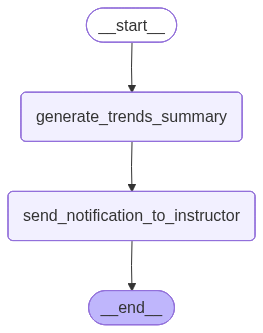

In [4]:
# Course Trends Summarization subgraph
class CourseTrendsSummarizationState(TypedDict):
    cleaned_submissions: List[AssignmentSubmission]
    trends_summary: str
    notification: str
    processed_submissions: List[str]

class CourseTrendsSummarizationOutputState(TypedDict):
    notification: str
    processed_submissions: List[str]

def generate_trends_summary(state):
    cleaned_submissions = state["cleaned_submissions"]
    # Add fxn: summary = summarize(cleaned_submissions)
    summary = "Students in Module 4 showing strong interest in parallelization and sub-graphs. LangGraph framework engagement is high."
    return {"trends_summary": summary, "processed_submissions": [f"trends-analysis-on-submission-{submission['id']}" for submission in cleaned_submissions]}

def send_notification_to_instructor(state):
    trends_summary = state["trends_summary"]
    # Add fxn: notification = generate_notification(trends_summary)
    notification = "Akshat's class performance summary sent to instructor dashboard"
    return {"notification": notification}

ct_builder = StateGraph(CourseTrendsSummarizationState, output_schema=CourseTrendsSummarizationOutputState)
ct_builder.add_node("generate_trends_summary", generate_trends_summary)
ct_builder.add_node("send_notification_to_instructor", send_notification_to_instructor)
ct_builder.add_edge(START, "generate_trends_summary")
ct_builder.add_edge("generate_trends_summary", "send_notification_to_instructor")
ct_builder.add_edge("send_notification_to_instructor", END)

graph = ct_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`. 

And we add our sub-graphs as nodes! 

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [5]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_submissions: List[AssignmentSubmission]
    cleaned_submissions: Annotated[List[AssignmentSubmission], add] # This will be USED BY in BOTH sub-graphs
    performance_report: str # This will only be generated in the Low Performance sub-graph
    notification: str # This will only be generated in the Course Trends sub-graph
    processed_submissions:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs


But, why does `cleaned_submissions` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_submissions: Annotated[List[AssignmentSubmission], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_submissions`.


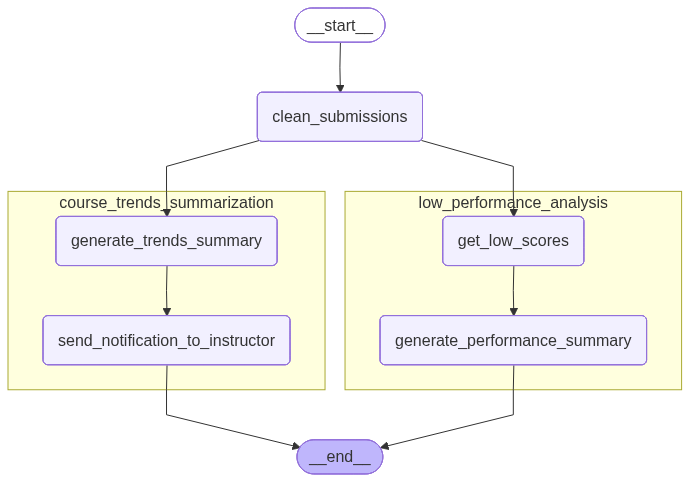

In [6]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_submissions: List[AssignmentSubmission]
    cleaned_submissions: List[AssignmentSubmission]
    performance_report: str # This will only be generated in the Low Performance sub-graph
    notification: str # This will only be generated in the Course Trends sub-graph
    processed_submissions:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_submissions(state):
    # Get submissions
    raw_submissions = state["raw_submissions"]
    # Data cleaning raw_submissions -> cleaned_submissions 
    cleaned_submissions = raw_submissions
    return {"cleaned_submissions": cleaned_submissions}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_submissions", clean_submissions)
entry_builder.add_node("course_trends_summarization", ct_builder.compile())
entry_builder.add_node("low_performance_analysis", lp_builder.compile())

entry_builder.add_edge(START, "clean_submissions")
entry_builder.add_edge("clean_submissions", "low_performance_analysis")
entry_builder.add_edge("clean_submissions", "course_trends_summarization")
entry_builder.add_edge("low_performance_analysis", END)
entry_builder.add_edge("course_trends_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [7]:
# Sample student submissions
high_score_submission = AssignmentSubmission(
    id="1",
    student_name="Akshat",
    course="LangGraph Academy Module 4",
    assignment="Parallelization Exercise",
    submission="Implemented parallel node execution with custom reducers and demonstrated fan-out/fan-in patterns.",
    score=95,
    reviewer="AI Teaching Assistant",
    comments="Excellent understanding of parallel workflows and state management."
)

low_score_submission = AssignmentSubmission(
    id="2",
    student_name="Student B",
    course="LangGraph Academy Module 4",
    assignment="Sub-graphs Exercise",
    submission="Attempted to create sub-graphs but struggled with state communication between parent and child graphs.",
    score=62,
    reviewer="AI Teaching Assistant",
    comments="Needs more practice with output schemas and understanding how sub-graphs access parent state."
)

raw_submissions = [high_score_submission, low_score_submission]
graph.invoke({"raw_submissions": raw_submissions})


{'raw_submissions': [{'id': '1',
   'student_name': 'Akshat',
   'course': 'LangGraph Academy Module 4',
   'assignment': 'Parallelization Exercise',
   'submission': 'Implemented parallel node execution with custom reducers and demonstrated fan-out/fan-in patterns.',
   'score': 95,
   'reviewer': 'AI Teaching Assistant',
   'comments': 'Excellent understanding of parallel workflows and state management.'},
  {'id': '2',
   'student_name': 'Student B',
   'course': 'LangGraph Academy Module 4',
   'assignment': 'Sub-graphs Exercise',
   'submission': 'Attempted to create sub-graphs but struggled with state communication between parent and child graphs.',
   'score': 62,
   'reviewer': 'AI Teaching Assistant',
   'comments': 'Needs more practice with output schemas and understanding how sub-graphs access parent state.'}],
 'cleaned_submissions': [{'id': '1',
   'student_name': 'Akshat',
   'course': 'LangGraph Academy Module 4',
   'assignment': 'Parallelization Exercise',
   'submissi

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r